# Creating features and target

## import packages and DataFrame

In [1]:
from features import Dataframe
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
polkadot = Dataframe().get_dataframe()

In [3]:
polkadot.head()

,date,current_price,current_price_sats,market_cap,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,Value_classification
0,2020-08-19,2.936665,25024.566687,0.000000e+00,0.000,0.750,193,7.200000,NaN,80,Extreme Greed
1,2020-08-20,2.936665,25024.566687,0.000000e+00,0.000,0.667,212,5.500000,NaN,75,Greed
2,2020-08-21,2.898791,24435.409268,0.000000e+00,0.000,1.727,237,6.333333,NaN,81,Extreme Greed
3,2020-08-22,2.871923,24934.417517,0.000000e+00,0.417,2.750,269,8.538462,NaN,78,Extreme Greed
4,2020-08-23,4.481389,38367.856477,4.028277e+09,1.091,5.364,313,16.500000,NaN,76,Extreme Greed


## create target

> create price in two days as target, then convert that into 0 (price less than the day before)
or 1 (price more than the day before)

In [4]:
polkadot['two_day_price'] = polkadot['current_price'].shift(-2)

In [5]:
polkadot['two_day_price'] = pd.Series(np.where(polkadot['two_day_price'].values < polkadot['two_day_price'].shift(-1), 0, 1),
          polkadot.index)

## create new features

In [6]:
polkadot['ema5'] = polkadot['current_price'].ewm(span=5, adjust=False).mean()
polkadot['ema20'] = polkadot['current_price'].ewm(span=20, adjust=False).mean()
polkadot['ema50'] = polkadot['current_price'].ewm(span=50, adjust=False).mean()

In [7]:
polkadot['fear_ema50'] = polkadot['Value'].ewm(span=50, adjust=False).mean()
polkadot['fear_change_2_weeks'] = polkadot['Value'] - polkadot['Value'].shift(-14)

In [8]:
polkadot['reddit_post_ema5'] = polkadot['reddit_post_48h'].ewm(span=5, adjust=False).mean()

In [9]:
polkadot['reddit_change_2_weeks'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(-14)

In [10]:
polkadot['sats_ema5'] = polkadot['current_price_sats'].ewm(span=5, adjust=False).mean()
polkadot['sats_ema20'] = polkadot['current_price_sats'].ewm(span=20, adjust=False).mean()
polkadot['sats_ema50'] = polkadot['current_price_sats'].ewm(span=50, adjust=False).mean()

In [11]:
polkadot['sats_change_3_days'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(-3)

In [12]:
polkadot.dropna(inplace=True)

## visual exploration of features

> visual exploration of features to determine best scaling method

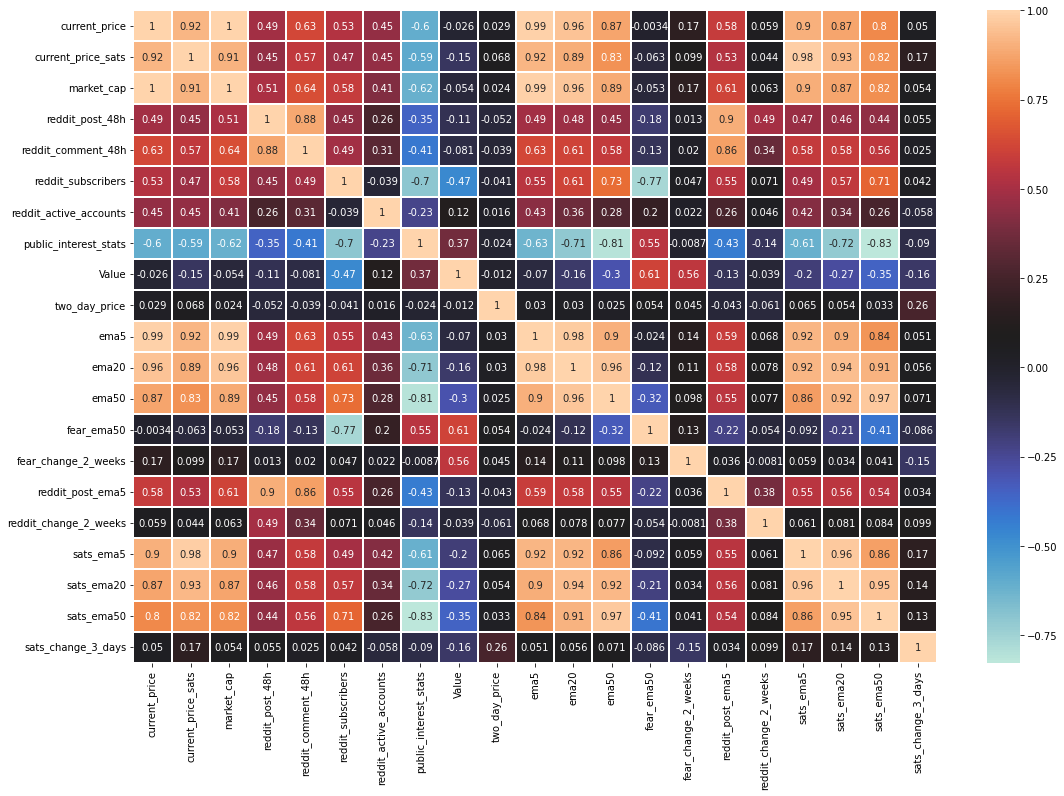

In [13]:
corr = polkadot.corr()
plt.figure(figsize=(18,12))
sns.heatmap(data=corr, annot=True,
            linewidths=0.2, linecolor='w', cmap='icefire');

> new features:
- three day change in price
- seven day change in price
- three day change in value
- seven day change in value
- reddit_post difference from three days ago
- reddit_post difference from seven days ago